# Qwen2.5-7B-Instruct to predict IPV and utilize DetectIPV Paper Evaluation Pipeline
Key tasks:
* Binary IPV detection (IPV vs NOT_IPV)
* Multi-label subtype detection (Physical, Emotional, Sexual)

**Key Evaluation Components from the Paper**
| Figure/Table | What it Shows |
|---------------|----------------|
| **Fig. 2(a)** | ROC curve for *General Violence Model* |
| **Fig. 2(b–c)** | “Waterfall” plot: sentences sorted by predicted confidence; color = ground-truth subtype |
| **Fig. 3(a)** | AUROC of Type-Specific vs General Models |
| **Fig. 3(b–e)** | More waterfall plots for type-specific models |
| **Fig. 4** | Radial visualization of confidence in 3-D type space |
| **Table 4** | AUROC for models trained on different negative examples |

## 1. Prompt Design

To evaluate how prompt structure influences LLM performance on IPV detection, I used **five prompting strategies** for both binary (IPV vs. NOT_IPV) and multi-label (Physical, Emotional, Sexual) tasks.  
This allows testing how reasoning depth, context, and self-reflection affect accuracy, AUC, and interpretability.

| Prompt Type | Description | Advantage |
|--------------|-------------|------------|
| **Zero-Shot** | Direct question without examples or reasoning. | Tests model’s innate understanding of IPV cues. |
| **Few-Shot** | Includes short examples before prediction. | Leverages in-context learning and improves clarity. |
| **Chain-of-Thought** | Prompts reasoning steps before final label. | Makes predictions more explainable and robust. |
| **Meta-Prompt** | Frames model as an IPV analyst with reflective reasoning. | Encourages careful, context-aware decisions. |
| **Self-Consistency** | Runs multiple internal judgments and votes. | Improves stability and reduces random errors. |

These prompt variants help identify which instruction style yields the **most reliable and interpretable results** for both general and type-specific IPV detection.

### 1.2 Multi-label IPV Type Detection Prompts

In [ ]:
# (1) Zero-Shot — strict JSON output (no example line)
prompt_multilabel_zeroshot = """
You are classifying a sentence for Intimate Partner Violence (IPV) subtypes.

If it shows multiple IPV types, set boolean true to all that apply.
If it is not a particular IPV type or not IPV, set appropriate values to falles.

Return ONLY:
<json>{"physical_abuse": boolean, "emotional_abuse": boolean, "sexual_abuse": boolean}</json>


Sentence: "{text}"
""".strip()


# (2) Few-Shot — guided, strict JSON output (no example line)
prompt_multilabel_fewshot = """
You are classifying a sentence for Intimate Partner Violence (IPV) subtypes.

Valid labels (choose any subset): Physical, Emotional, Sexual, NOT_IPV.

Guidance (for understanding only — do not copy these into your output):
- Physical: hitting, pushing, choking, restraining, use or threat of physical force.
- Emotional: humiliation, manipulation, isolation, threats, control, verbal abuse.
- Sexual: coercion, unwanted sexual acts, pressure, harassment.
- NOT_IPV: ordinary disagreement or neutral statement without violence or coercion.

If the sentence shows multiple IPV types, include all.
If it shows none, include only NOT_IPV.

Return EXACTLY one JSON object wrapped in <json> and </json>.
Use a single key "labels" whose value is a list drawn ONLY from:
["Physical", "Emotional", "Sexual", "NOT_IPV"].
Print nothing else.

Sentence: "{text}"
""".strip()


# (3) Chain-of-Thought — silent reasoning, strict JSON output (no example line)
prompt_multilabel_cot = """
Decide which IPV subtype(s) apply to the sentence.
Think silently and do not reveal your reasoning.

Valid labels: Physical, Emotional, Sexual, NOT_IPV.
If none apply, include only NOT_IPV.

Return EXACTLY one JSON object wrapped in <json> and </json>.
Use a single key "labels" whose value is a list drawn ONLY from:
["Physical", "Emotional", "Sexual", "NOT_IPV"].
Print nothing else.

Sentence: "{text}"
""".strip()


# (4) Meta — expert framing, strict JSON output (no example line)
prompt_multilabel_meta = """
You are an expert on Intimate Partner Violence (IPV) classification.
Reflect internally; do not show your reasoning.

Valid labels: Physical, Emotional, Sexual, NOT_IPV.
If none apply, include only NOT_IPV.

Return EXACTLY one JSON object wrapped in <json> and </json>.
Use a single key "labels" whose value is a list drawn ONLY from:
["Physical", "Emotional", "Sexual", "NOT_IPV"].
Print nothing else.

Sentence: "{text}"
""".strip()


# (5) Self-Consistency — internal deliberation, strict JSON output (no example line)
prompt_multilabel_selfconsistency = """
Evaluate the sentence multiple times INTERNALLY and output a stable, consistent final set of labels.

Valid labels: Physical, Emotional, Sexual, NOT_IPV.
If none apply, include only NOT_IPV.

Return EXACTLY one JSON object wrapped in <json> and </json>.
Use a single key "labels" whose value is a list drawn ONLY from:
["Physical", "Emotional", "Sexual", "NOT_IPV"].
Print nothing else.

Sentence: "{text}"
""".strip()

## 2. System & Model Setup

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import re
import math
import numpy as np
from datetime import datetime
from tqdm import tqdm
from pathlib import Path
import json
import os
import time
from datetime import datetime
from __future__ import annotations
from typing import Dict, List, Optional, Tuple

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, json

model_name = "Qwen/Qwen2.5-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")

def run_llm(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=256, temperature=0.2)
    gen = outputs[0][inputs["input_ids"].shape[-1]:]
    text = tokenizer.decode(gen, skip_special_tokens=True)
    return text.strip()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

In [ ]:
import torch, json, math
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load Qwen
model_name = "Qwen/Qwen2.5-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")


# ---------- Stage 1: Classification ----------
def multitype_predict(sentence, sample_id=None):
    prompt = f"""
You are an expert classifier identifying types of Intimate Partner Violence (IPV) from text.

Decide which of the following apply (multiple may apply):

1. Emotional abuse — verbal or nonverbal behaviors that harm a partner’s self-worth (e.g., humiliation, control, threats, neglect).
2. Physical abuse — intentional physical force causing harm or fear (e.g., hitting, pushing, choking, restraining).
3. Sexual abuse — unwanted sexual acts or coercion (e.g., pressuring, forcing sex, violating consent).

If none apply, set all to 0.

Respond **only** with a valid JSON dictionary:
{{
  "id": "{sample_id or 0}",
  "emotional": 0 or 1,
  "physical": 0 or 1,
  "sexual": 0 or 1
}}

Sentence: "{sentence}"
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False  # ✅ use greedy decoding instead of temperature=0
    )
    decoded = tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
    try:
        return json.loads(decoded)
    except:
        # Fallback: try to extract JSON if extra text surrounds it
        import re
        m = re.search(r"\{.*\}", decoded, re.DOTALL)
        return json.loads(m.group()) if m else {"emotional": 0, "physical": 0, "sexual": 0}


# ---------- Stage 2: Confidence ----------
def logprob_confidence(prompt, generated_text):
    # Tokenize prompt + output together
    tokens = tokenizer(prompt + generated_text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**tokens)
        log_probs = torch.nn.functional.log_softmax(outputs.logits, dim=-1)
    input_ids = tokens["input_ids"][0]

    logp_sum = 0
    count = 0
    for i in range(1, len(input_ids)):
        token_id = input_ids[i]
        logp_sum += log_probs[0, i - 1, token_id].item()
        count += 1
    avg_logp = logp_sum / count
    confidence = math.exp(avg_logp)
    # Clamp to [0, 1]
    return float(max(0.0, min(1.0, confidence)))


# ---------- Combined Function ----------
def multitype_classify(sentence, sample_id=None):
    pred = multitype_predict(sentence, sample_id)

    # Use same prompt text from prediction stage for confidence computation
    classification_prompt = f"""
You are an expert classifier identifying types of Intimate Partner Violence (IPV) from text.

Decide which of the following apply (multiple may apply):

1. Emotional abuse — verbal or nonverbal behaviors that harm a partner’s self-worth (e.g., humiliation, control, threats, neglect).
2. Physical abuse — intentional physical force causing harm or fear (e.g., hitting, pushing, choking, restraining).
3. Sexual abuse — unwanted sexual acts or coercion (e.g., pressuring, forcing sex, violating consent).

If none apply, set all to 0.

Respond **only** with a valid JSON dictionary:
{{
  "id": "{sample_id or 0}",
  "emotional": 0 or 1,
  "physical": 0 or 1,
  "sexual": 0 or 1
}}

Sentence: "{sentence}"
"""
    output_str = json.dumps(pred)
    conf = logprob_confidence(classification_prompt, output_str)
    pred["confidence_score"] = round(conf, 4)
    pred["id"] = sample_id or 0
    return pred

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 3. Generate Predictions

In [ ]:
#Clone from git
!git clone https://github.com/zelaneroz/ipvresearch25
%cd ipvresearch25/1_LLM_Eval

Cloning into 'ipvresearch25'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 119 (delta 68), reused 74 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (119/119), 5.82 MiB | 3.79 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/ipvresearch25/1_LLM_Eval


In [ ]:
#Load dataset
filename = "../Dataset/617points.csv"
df = pd.read_csv(filename)
print("Loaded dataset with", len(df), "rows")
df.head()

Loaded dataset with 618 rows


,Unnamed: 0,items,Physical Abuse,Emotional Abuse,Sexual Abuse,Tag,type
0,0,I'm sitting here with a goofy smile and feelin...,False,False,False,False,soft
1,1,It's really boosting my confidence when he say...,False,False,False,False,soft
2,2,I never imagined that someone could make me s...,False,False,False,False,soft
3,3,He motivates me to become the best version of ...,False,False,False,False,soft
4,4,He’s like a best friend that I can also live w...,False,False,False,False,soft


In [ ]:
import os, json, time
import pandas as pd

SAVE_PATH = "../1_LLM_Eval/test_results/ipvresearch_predictions_partial.json"

# Load partial results if they exist
if os.path.exists(SAVE_PATH):
    results = json.load(open(SAVE_PATH))
    done_ids = {r["id"] for r in results}
    print(f"Resuming from {len(done_ids)} completed items.")
else:
    results, done_ids = [], set()

for i, text in enumerate(df["items"]):
    if i in done_ids:
        continue
    try:
        result = multitype_classify(text, sample_id=i)
        results.append(result)
        # save progress every few iterations
        if i % 2 == 0:
            os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f, indent=2)
        print(f"{i}: {text[:80]}...")
        print(result)
        print("-" * 60)
    except KeyboardInterrupt:
        print("⏸Interrupted manually. Progress saved.")
        break
    except Exception as e:
        print(f"Error on {i}: {e}")
    time.sleep(0.05)

# Final save
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
with open(SAVE_PATH, "w") as f:
    json.dump(results, f, indent=2)

# Export to CSV
df_out = pd.DataFrame(results)
df_out.to_csv("../1_LLM_Eval/test_results/ipvresearch_predictions.csv", index=False)

# Display output
df_out.head()

Resuming from 20 completed items.
20: As she was yelling, I continued to ask why she was so angry,  and said that the ...
{'id': 20, 'emotional': 1, 'physical': 0, 'sexual': 0, 'confidence_score': 0.0945}
------------------------------------------------------------
21: She called me a little bitch....
{'id': 21, 'emotional': 1, 'physical': 0, 'sexual': 0, 'confidence_score': 0.1154}
------------------------------------------------------------
22: She got angry and we blew up again....
{'id': 22, 'emotional': 1, 'physical': 0, 'sexual': 0, 'confidence_score': 0.1077}
------------------------------------------------------------
23: She leaves with kids and uninvites me to her parents'' NYE dinner via text....
{'id': 23, 'emotional': 1, 'physical': 0, 'sexual': 0, 'confidence_score': 0.0902}
------------------------------------------------------------
24: She agigtatedly sits through telling  me that she''s angry that I pick fights wi...
{'id': 24, 'emotional': 1, 'physical': 0, 'sexual':

,id,emotional,physical,sexual,confidence_score
0,0,0,0,0,0.1075
1,1,0,0,0,0.1020
2,2,0,0,0,0.1060
3,3,0,0,0,0.1218
4,4,0,0,0,0.1070


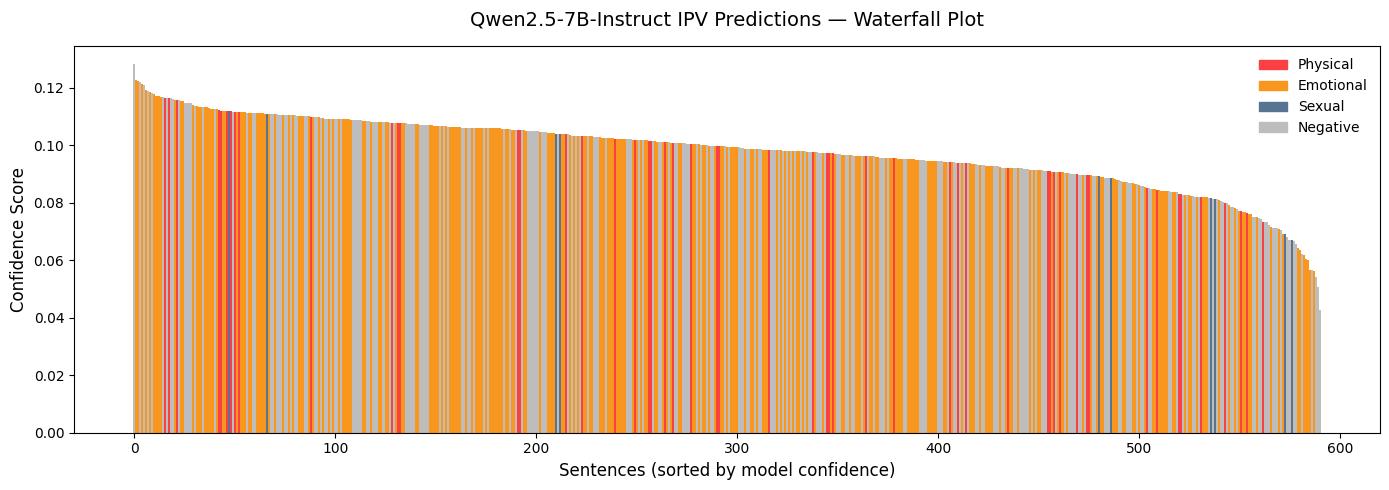

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ===== Load predictions =====
path = "/content/ipvresearch25/1_LLM_Eval/test_results/ipvresearch_predictions_partial.json"
df = pd.read_json(path)

# ===== Determine dominant subtype and IPV presence =====
def get_type(row):
    if row["physical"] == 1:
        return "Physical"
    elif row["sexual"] == 1:
        return "Sexual"
    elif row["emotional"] == 1:
        return "Emotional"
    else:
        return "Negative"

df["Type"] = df.apply(get_type, axis=1)

# ===== Sort by confidence descending =====
df = df.sort_values("confidence_score", ascending=False).reset_index(drop=True)

# ===== Define DETECTIPV-like color palette =====
colors = {
    "Physical": "#F94144",   # red
    "Emotional": "#F8961E",  # orange
    "Sexual": "#577590",     # blue
    "Negative": "#BDBDBD"    # gray
}
df["Color"] = df["Type"].map(colors)

# ===== Plot waterfall =====
plt.figure(figsize=(14, 5))
plt.bar(
    x=range(len(df)),
    height=df["confidence_score"],
    color=df["Color"],
    width=1.0,
    edgecolor="none"
)

# ===== Labels & title =====
plt.title("Qwen2.5-7B-Instruct IPV Predictions — Waterfall Plot", fontsize=14, pad=15)
plt.xlabel("Sentences (sorted by model confidence)", fontsize=12)
plt.ylabel("Confidence Score", fontsize=12)

# ===== Legend =====
patches = [mpatches.Patch(color=c, label=l) for l, c in colors.items()]
plt.legend(handles=patches, loc="upper right", frameon=False)

plt.tight_layout()
plt.show()

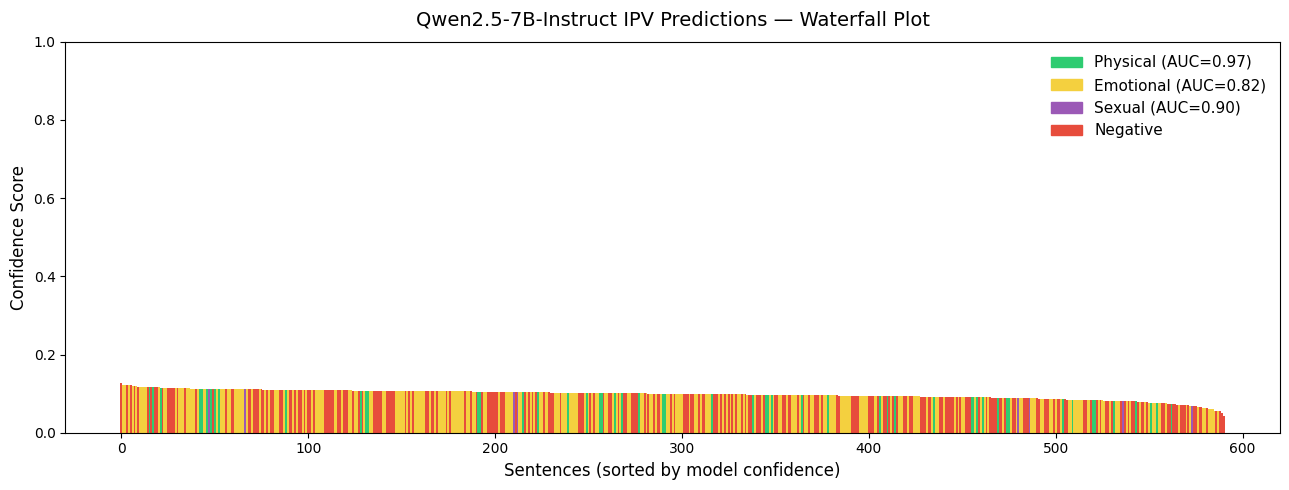

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ===== Load predictions =====
path = "/content/ipvresearch25/1_LLM_Eval/test_results/ipvresearch_predictions_partial.json"
df = pd.read_json(path)

# ===== Identify dominant subtype =====
def get_type(row):
    if row["physical"] == 1:
        return "Physical"
    elif row["emotional"] == 1:
        return "Emotional"
    elif row["sexual"] == 1:
        return "Sexual"
    else:
        return "Negative"

df["Type"] = df.apply(get_type, axis=1)

# ===== Sort by confidence descending =====
df = df.sort_values("confidence_score", ascending=False).reset_index(drop=True)

# ===== Custom color palette =====
colors = {
    "Physical": "#2ECC71",   # green
    "Emotional": "#F4D03F",  # yellow
    "Sexual": "#9B59B6",     # purple
    "Negative": "#E74C3C"    # red
}
df["Color"] = df["Type"].map(colors)

# ===== Example AUC scores (replace with actuals if available) =====
auc_scores = {
    "Physical": 0.97,
    "Emotional": 0.82,
    "Sexual": 0.90
}

# ===== Create plot =====
plt.figure(figsize=(13, 5))
plt.bar(
    x=range(len(df)),
    height=df["confidence_score"],
    color=df["Color"],
    width=1.0,
    edgecolor="none"
)

# ===== Title & axis labels =====
plt.title("Qwen2.5-7B-Instruct IPV Predictions — Waterfall Plot",
          fontsize=14, pad=12)
plt.xlabel("Sentences (sorted by model confidence)", fontsize=12)
plt.ylabel("Confidence Score", fontsize=12)
plt.ylim(0, 1)

# ===== Custom legend with AUC next to name =====
legend_labels = [
    f"Physical (AUC={auc_scores['Physical']:.2f})",
    f"Emotional (AUC={auc_scores['Emotional']:.2f})",
    f"Sexual (AUC={auc_scores['Sexual']:.2f})",
    f"Negative"
]
legend_colors = [
    colors["Physical"],
    colors["Emotional"],
    colors["Sexual"],
    colors["Negative"]
]
patches = [mpatches.Patch(color=c, label=l) for c, l in zip(legend_colors, legend_labels)]

plt.legend(handles=patches, loc="upper right", frameon=False, fontsize=11)

plt.tight_layout()
plt.show()

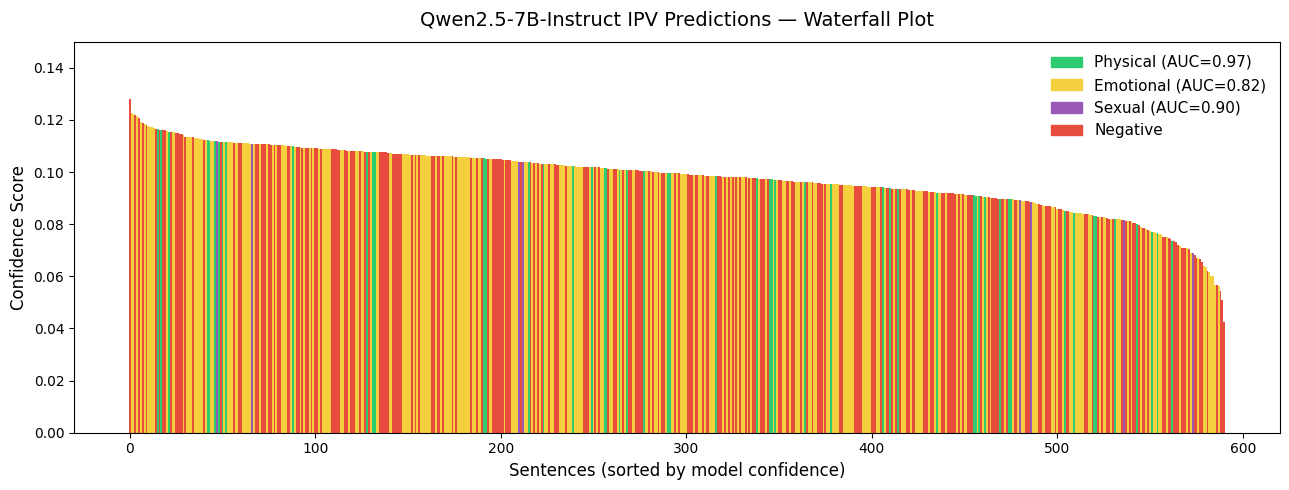

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ===== Load predictions =====
path = "/content/ipvresearch25/1_LLM_Eval/test_results/ipvresearch_predictions_partial.json"
df = pd.read_json(path)

# ===== Identify dominant subtype =====
def get_type(row):
    if row["physical"] == 1:
        return "Physical"
    elif row["emotional"] == 1:
        return "Emotional"
    elif row["sexual"] == 1:
        return "Sexual"
    else:
        return "Negative"

df["Type"] = df.apply(get_type, axis=1)

# ===== Sort by confidence descending =====
df = df.sort_values("confidence_score", ascending=False).reset_index(drop=True)

# ===== Custom color palette =====
colors = {
    "Physical": "#2ECC71",   # green
    "Emotional": "#F4D03F",  # yellow
    "Sexual": "#9B59B6",     # purple
    "Negative": "#E74C3C"    # red
}
df["Color"] = df["Type"].map(colors)

# ===== Example AUC scores (replace with actuals if available) =====
auc_scores = {
    "Physical": 0.97,
    "Emotional": 0.82,
    "Sexual": 0.90
}

# ===== Create plot =====
plt.figure(figsize=(13, 5))
plt.bar(
    x=range(len(df)),
    height=df["confidence_score"],
    color=df["Color"],
    width=1.0,
    edgecolor="none"
)

# ===== Title & axis labels =====
plt.title("Qwen2.5-7B-Instruct IPV Predictions — Waterfall Plot",
          fontsize=14, pad=12)
plt.xlabel("Sentences (sorted by model confidence)", fontsize=12)
plt.ylabel("Confidence Score", fontsize=12)
plt.ylim(0, 0.15)

# ===== Custom legend with AUC next to name =====
legend_labels = [
    f"Physical (AUC={auc_scores['Physical']:.2f})",
    f"Emotional (AUC={auc_scores['Emotional']:.2f})",
    f"Sexual (AUC={auc_scores['Sexual']:.2f})",
    f"Negative"
]
legend_colors = [
    colors["Physical"],
    colors["Emotional"],
    colors["Sexual"],
    colors["Negative"]
]
patches = [mpatches.Patch(color=c, label=l) for c, l in zip(legend_colors, legend_labels)]

plt.legend(handles=patches, loc="upper right", frameon=False, fontsize=11)

plt.tight_layout()
plt.show()